# **Importing the Data**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from joblib import Parallel, delayed
import os
import multiprocessing

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as skm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For Barouyr
#data1 = pd.read_csv("BETN073-1990_2012.csv")
#data2 = pd.read_csv("BETN073-2013_2022.csv")
#ozone_data = pd.concat([data1,data2])
#ozone_data = ozone_data.reset_index()

In [83]:
# For Luis
data1 = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/BETN073-1990_2012.csv")
data2 = pd.read_csv("/content/drive/My Drive/DataThesis/BETN073/BETN073-2013_2022.csv")
ozone_data = pd.concat([data1,data2])
ozone_data = ozone_data.reset_index()

# **Preprocessing**

Select the data where that will be used for the model which includes the hourly data from 2008 to 2019. The unnecessary columns are moved to only keep the columns with concentration values and the date and time at which each concentration is measured.

## Making Concentration values NA for validity = 0 and validity = 1

In [84]:
ozone_data.head()

,index,Samplingpoint,Pollutant,Start,End,Value,Unit,AggType,Validity,Verification,ResultTime,DataCapture,FkObservationLog
0,0,BE/SPO-BETN073_00007_100,7,1990-01-01T00:00:00,1990-01-01T01:00:00,47.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
1,1,BE/SPO-BETN073_00007_100,7,1990-01-01T01:00:00,1990-01-01T02:00:00,46.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
2,2,BE/SPO-BETN073_00007_100,7,1990-01-01T02:00:00,1990-01-01T03:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
3,3,BE/SPO-BETN073_00007_100,7,1990-01-01T03:00:00,1990-01-01T04:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN
4,4,BE/SPO-BETN073_00007_100,7,1990-01-01T04:00:00,1990-01-01T05:00:00,48.0,ug.m-3,hour,1,1,2016-08-17T07:51:15.530,0,NaN


In [85]:
ozone_data['Validity'].unique()

array([ 1, -1,  0])

In [86]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [87]:
# Check rows with Validity = 0 or Validity = -1 and set Value to NaN
ozone_data.loc[(ozone_data['Validity'] == 0) | (ozone_data['Validity'] == -1), 'Value'] = None

In [88]:
# Display examples for each unique value in 'Validity' column
for value in ozone_data['Validity'].unique():
    examples = ozone_data[ozone_data['Validity'] == value].head()
    print(f"Examples for Validity {value}:\n{examples}\n")

Examples for Validity 1:
   index             Samplingpoint  Pollutant                Start  \
0      0  BE/SPO-BETN073_00007_100          7  1990-01-01T00:00:00   
1      1  BE/SPO-BETN073_00007_100          7  1990-01-01T01:00:00   
2      2  BE/SPO-BETN073_00007_100          7  1990-01-01T02:00:00   
3      3  BE/SPO-BETN073_00007_100          7  1990-01-01T03:00:00   
4      4  BE/SPO-BETN073_00007_100          7  1990-01-01T04:00:00   

                   End  Value    Unit AggType  Validity  Verification  \
0  1990-01-01T01:00:00   47.0  ug.m-3    hour         1             1   
1  1990-01-01T02:00:00   46.0  ug.m-3    hour         1             1   
2  1990-01-01T03:00:00   48.0  ug.m-3    hour         1             1   
3  1990-01-01T04:00:00   48.0  ug.m-3    hour         1             1   
4  1990-01-01T05:00:00   48.0  ug.m-3    hour         1             1   

                ResultTime  DataCapture FkObservationLog  
0  2016-08-17T07:51:15.530            0              NaN

In [89]:
columns_remove = ['Samplingpoint','Pollutant','End','Unit','AggType','Validity','Verification','ResultTime','DataCapture','FkObservationLog','index']
ozone_data = ozone_data.drop(columns=columns_remove)

# Sampling Point: BE/SPO-BETN073_00007_100
# Pollutant: 7 (O_3)
# End: Start with 1 hour added
# Unit: ug.m-3
# Aggregation Type: hour
# Validaity/Verification: 1 & 1
# Result Time: Time and Date when data is added to the whole data file
# Data Capture: 0
# FkObservation log: Do not know meaning, values from NaN to 0fa5da4d-ae92-4bb7-bcd4-07fb6b962ae4

ozone_data['Start'] = pd.to_datetime(ozone_data['Start'])
data = ozone_data[(ozone_data['Start'].dt.year >= 2008) & (ozone_data['Start'].dt.year <= 2019)]
data = data.reset_index()
data = data.drop(columns=['index'])
data.rename(columns={'Value': 'Concentration'}, inplace=True)

Thus the following dataframe only

In [90]:
data.head()

,Start,Concentration
0,2008-01-01 00:00:00,0.0
1,2008-01-01 01:00:00,1.0
2,2008-01-01 02:00:00,0.0
3,2008-01-01 03:00:00,2.0
4,2008-01-01 04:00:00,1.0


The data is checked to make sure there are no duplicates.

In [91]:
duplicates = data.duplicated(subset=['Start'])

# Print or further process the duplicate values
print("Duplicate values in the column Start:", duplicates.any())

Duplicate values in the column Start: False


## Adding new variables

From the Start column, we extracr the year, month, day and time.

In [92]:
# Extract year, month, day, and time into separate columns
data['Year'] = data['Start'].dt.year
data['Month'] = data['Start'].dt.month
data['Day'] = data['Start'].dt.day
data['Time'] = data['Start'].dt.time

# Display the transformed DataFrame
print(data.head())

                Start  Concentration  Year  Month  Day      Time
0 2008-01-01 00:00:00            0.0  2008      1    1  00:00:00
1 2008-01-01 01:00:00            1.0  2008      1    1  01:00:00
2 2008-01-01 02:00:00            0.0  2008      1    1  02:00:00
3 2008-01-01 03:00:00            2.0  2008      1    1  03:00:00
4 2008-01-01 04:00:00            1.0  2008      1    1  04:00:00


From the Start column the day of the week can be extracted, which can also be used to determine if that measurement was taken during the weekend.

In [93]:
# Extract day of the week
data['DayOfWeek'] = (data['Start'].dt.weekday + 1) % 7

# Create a new column indicating whether the day is a weekend or not
data['Weekend'] = (data['Start'].dt.dayofweek // 5).astype(int)

In [94]:
data.head()

,Start,Concentration,Year,Month,Day,Time,DayOfWeek,Weekend
0,2008-01-01 00:00:00,0.0,2008,1,1,00:00:00,2,0
1,2008-01-01 01:00:00,1.0,2008,1,1,01:00:00,2,0
2,2008-01-01 02:00:00,0.0,2008,1,1,02:00:00,2,0
3,2008-01-01 03:00:00,2.0,2008,1,1,03:00:00,2,0
4,2008-01-01 04:00:00,1.0,2008,1,1,04:00:00,2,0


## Converting the negative values

Missing values are represented by negative concentration values. Thus, these will be converted to NaN to be able to used the describe function to attain some basic measures.

In [95]:
# Can check the issue here
data['Concentration'].describe()

count    99114.000000
mean        45.017011
std         28.889379
min          0.000000
25%         23.000000
50%         43.500000
75%         62.000000
max        238.000000
Name: Concentration, dtype: float64

In [96]:
count_below_zero = (data['Concentration'] < 0).sum()

# Print the count
print("Number of observations with values below 0:", count_below_zero)

data.loc[data['Concentration'] < 0, 'Concentration'] = np.nan

Number of observations with values below 0: 0


In [97]:
data['Concentration'].isna().sum()

5381

Thus, there are 5381 missing observation for the BETN073 station between the years 2008 and 2019.

In [98]:
data['Concentration'].describe()

count    99114.000000
mean        45.017011
std         28.889379
min          0.000000
25%         23.000000
50%         43.500000
75%         62.000000
max        238.000000
Name: Concentration, dtype: float64

## Making the data daily, using 8 hour Mean Max



In [99]:
# Calculate the 8-hour rolling mean
eight_hour_rolling_mean = data.groupby(['Year', 'Month', 'Day'])['Concentration'].rolling(window=8).mean().reset_index(drop=True)

# Add the 8-hour rolling mean as a new column in the original DataFrame
data['EightHourRollingMean'] = eight_hour_rolling_mean

# Group by 'Year', 'Month', and 'Day', and find the daily maximum of the 8-hour mean
data = data.groupby(['Year', 'Month', 'Day']).agg({'EightHourRollingMean': 'max', 'DayOfWeek': 'first', 'Weekend': 'first'}).reset_index()

In [101]:
data.rename(columns={'EightHourRollingMean': 'Concentration'}, inplace=True)

In [102]:
data

,Year,Month,Day,Concentration,DayOfWeek,Weekend
0,2008,1,1,18.5000,2,0
1,2008,1,2,46.1250,3,0
2,2008,1,3,38.2500,4,0
3,2008,1,4,33.1250,5,0
4,2008,1,5,68.2500,6,1
...,...,...,...,...,...,...
4349,2019,12,27,45.2500,5,0
4350,2019,12,28,42.1250,6,1
4351,2019,12,29,32.8750,0,1
4352,2019,12,30,41.6875,1,0


In [103]:
nan_count = data['Concentration'].isna().sum()
print("Number of NaN values in 'Concentration':", nan_count)

Number of NaN values in 'Concentration': 80


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4354 entries, 0 to 4353
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4354 non-null   int64  
 1   Month          4354 non-null   int64  
 2   Day            4354 non-null   int64  
 3   Concentration  4274 non-null   float64
 4   DayOfWeek      4354 non-null   int64  
 5   Weekend        4354 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 204.2 KB


In [105]:
# Check for NaN values in the entire DataFrame
nan_rows = data[data.isna().any(axis=1)]

# Print the rows with NaN values
print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
      Year  Month  Day  Concentration  DayOfWeek  Weekend
41    2008      2   11            NaN          1        0
42    2008      2   12            NaN          2        0
43    2008      2   13            NaN          3        0
44    2008      2   14            NaN          4        0
138   2008      5   18            NaN          0        1
...    ...    ...  ...            ...        ...      ...
4052  2019      3    5            NaN          2        0
4053  2019      3    6            NaN          3        0
4054  2019      3    7            NaN          4        0
4055  2019      3    8            NaN          5        0
4113  2019      5    5            NaN          0        1

[80 rows x 6 columns]


In [ ]:
#data['Concentration'] = np.interp(data.index, data.dropna().index, data['Concentration'].dropna())

In [ ]:
#nan_count = data['Concentration'].isna().sum()
#print("Number of NaN values in 'Concentration':", nan_count)

In [106]:
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

data.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend
Date,,,,,,
2008-01-01,2008,1,1,18.500,2,0
2008-01-02,2008,1,2,46.125,3,0
2008-01-03,2008,1,3,38.250,4,0
2008-01-04,2008,1,4,33.125,5,0
2008-01-05,2008,1,5,68.250,6,1


# **ARIMA model**

## A new variable based on the optimal SARIMA is made

In [107]:
### We first create a new dataset,interpolate the missing values so that we can perform ARIMA
# Assuming data is your DataFrame
data_a = data.copy()

In [108]:
data_a['Concentration'] = data_a['Concentration'].interpolate(method='linear')

In [109]:
# Assuming data_a is your DataFrame
columns_to_drop = ['Year', 'Month', 'Day', 'DayOfWeek', 'Weekend']

# Drop the specified columns from data_a
data_a = data_a.drop(columns=columns_to_drop)

data_a.isna().sum()
data_a.head()

,Concentration
Date,
2008-01-01,18.500
2008-01-02,46.125
2008-01-03,38.250
2008-01-04,33.125
2008-01-05,68.250


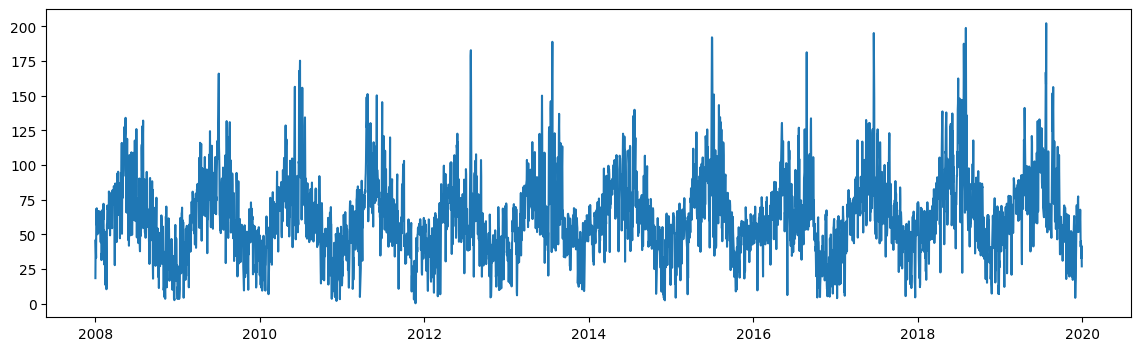

In [110]:
plt.figure(figsize=(14,4))
plt.plot(data_a.Concentration)

In [111]:
data_b = data_a.copy()
data_b = data_b.reset_index()

In [112]:
data_b

,Date,Concentration
0,2008-01-01,18.5000
1,2008-01-02,46.1250
2,2008-01-03,38.2500
3,2008-01-04,33.1250
4,2008-01-05,68.2500
...,...,...
4349,2019-12-27,45.2500
4350,2019-12-28,42.1250
4351,2019-12-29,32.8750
4352,2019-12-30,41.6875


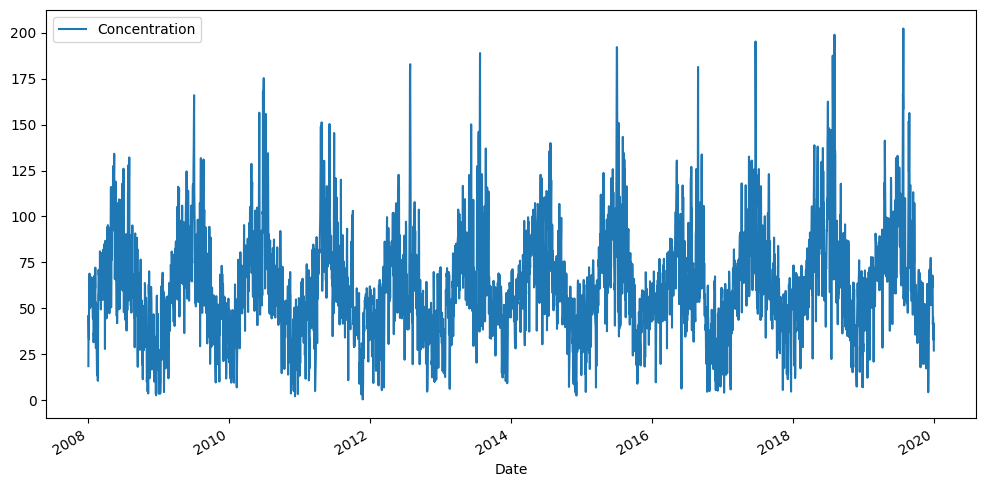

In [113]:
data_b['Date'] = pd.to_datetime(data_b['Date'])  # Convert date column to DateTime
ax = data_b.plot(x='Date', y='Concentration', figsize=(12, 6))

plt.show()

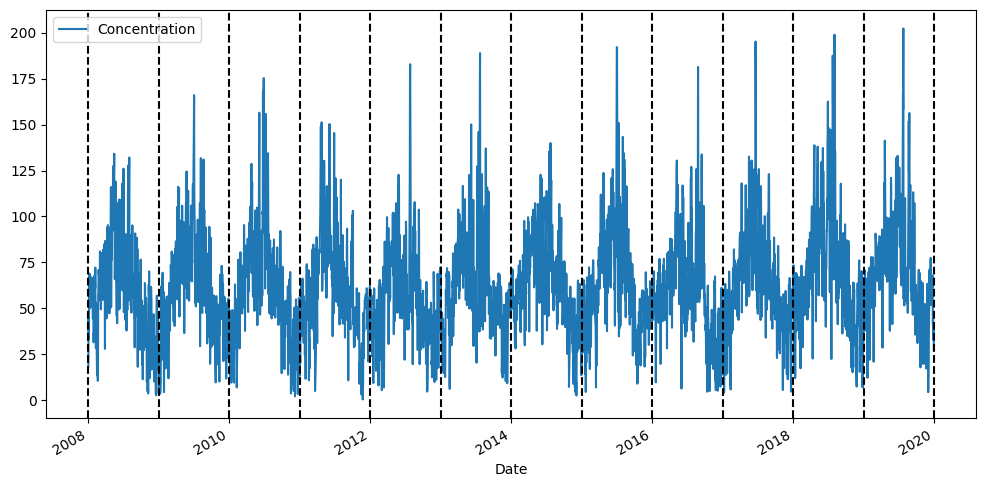

In [114]:
ax = data_b.plot(x='Date', y='Concentration', figsize=(12,6))
xcoords = ['2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

##### We can slightly observe seasonality

In [115]:
data_a.dropna(subset=['Concentration'], inplace=True)

In [116]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data_a)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print('The time series is likely stationary.')
else:
    print('The time series is likely non-stationary.')

ADF Statistic: -5.208688697029805
p-value: 8.439989293395134e-06
Critical Values: {'1%': -3.4318618259487974, '5%': -2.8622080407621366, '10%': -2.5671256028256875}
The time series is likely stationary.


## Analysed stationarity

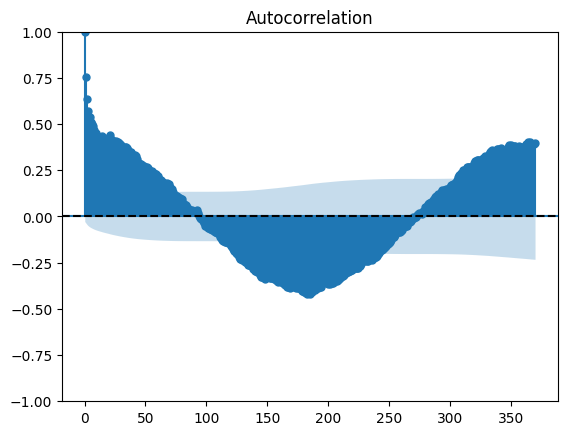

In [117]:
acf_plot = plot_acf(data_a.Concentration, lags=370)
plt.axhline(y=0, color='black', linestyle='--')

plt.show()

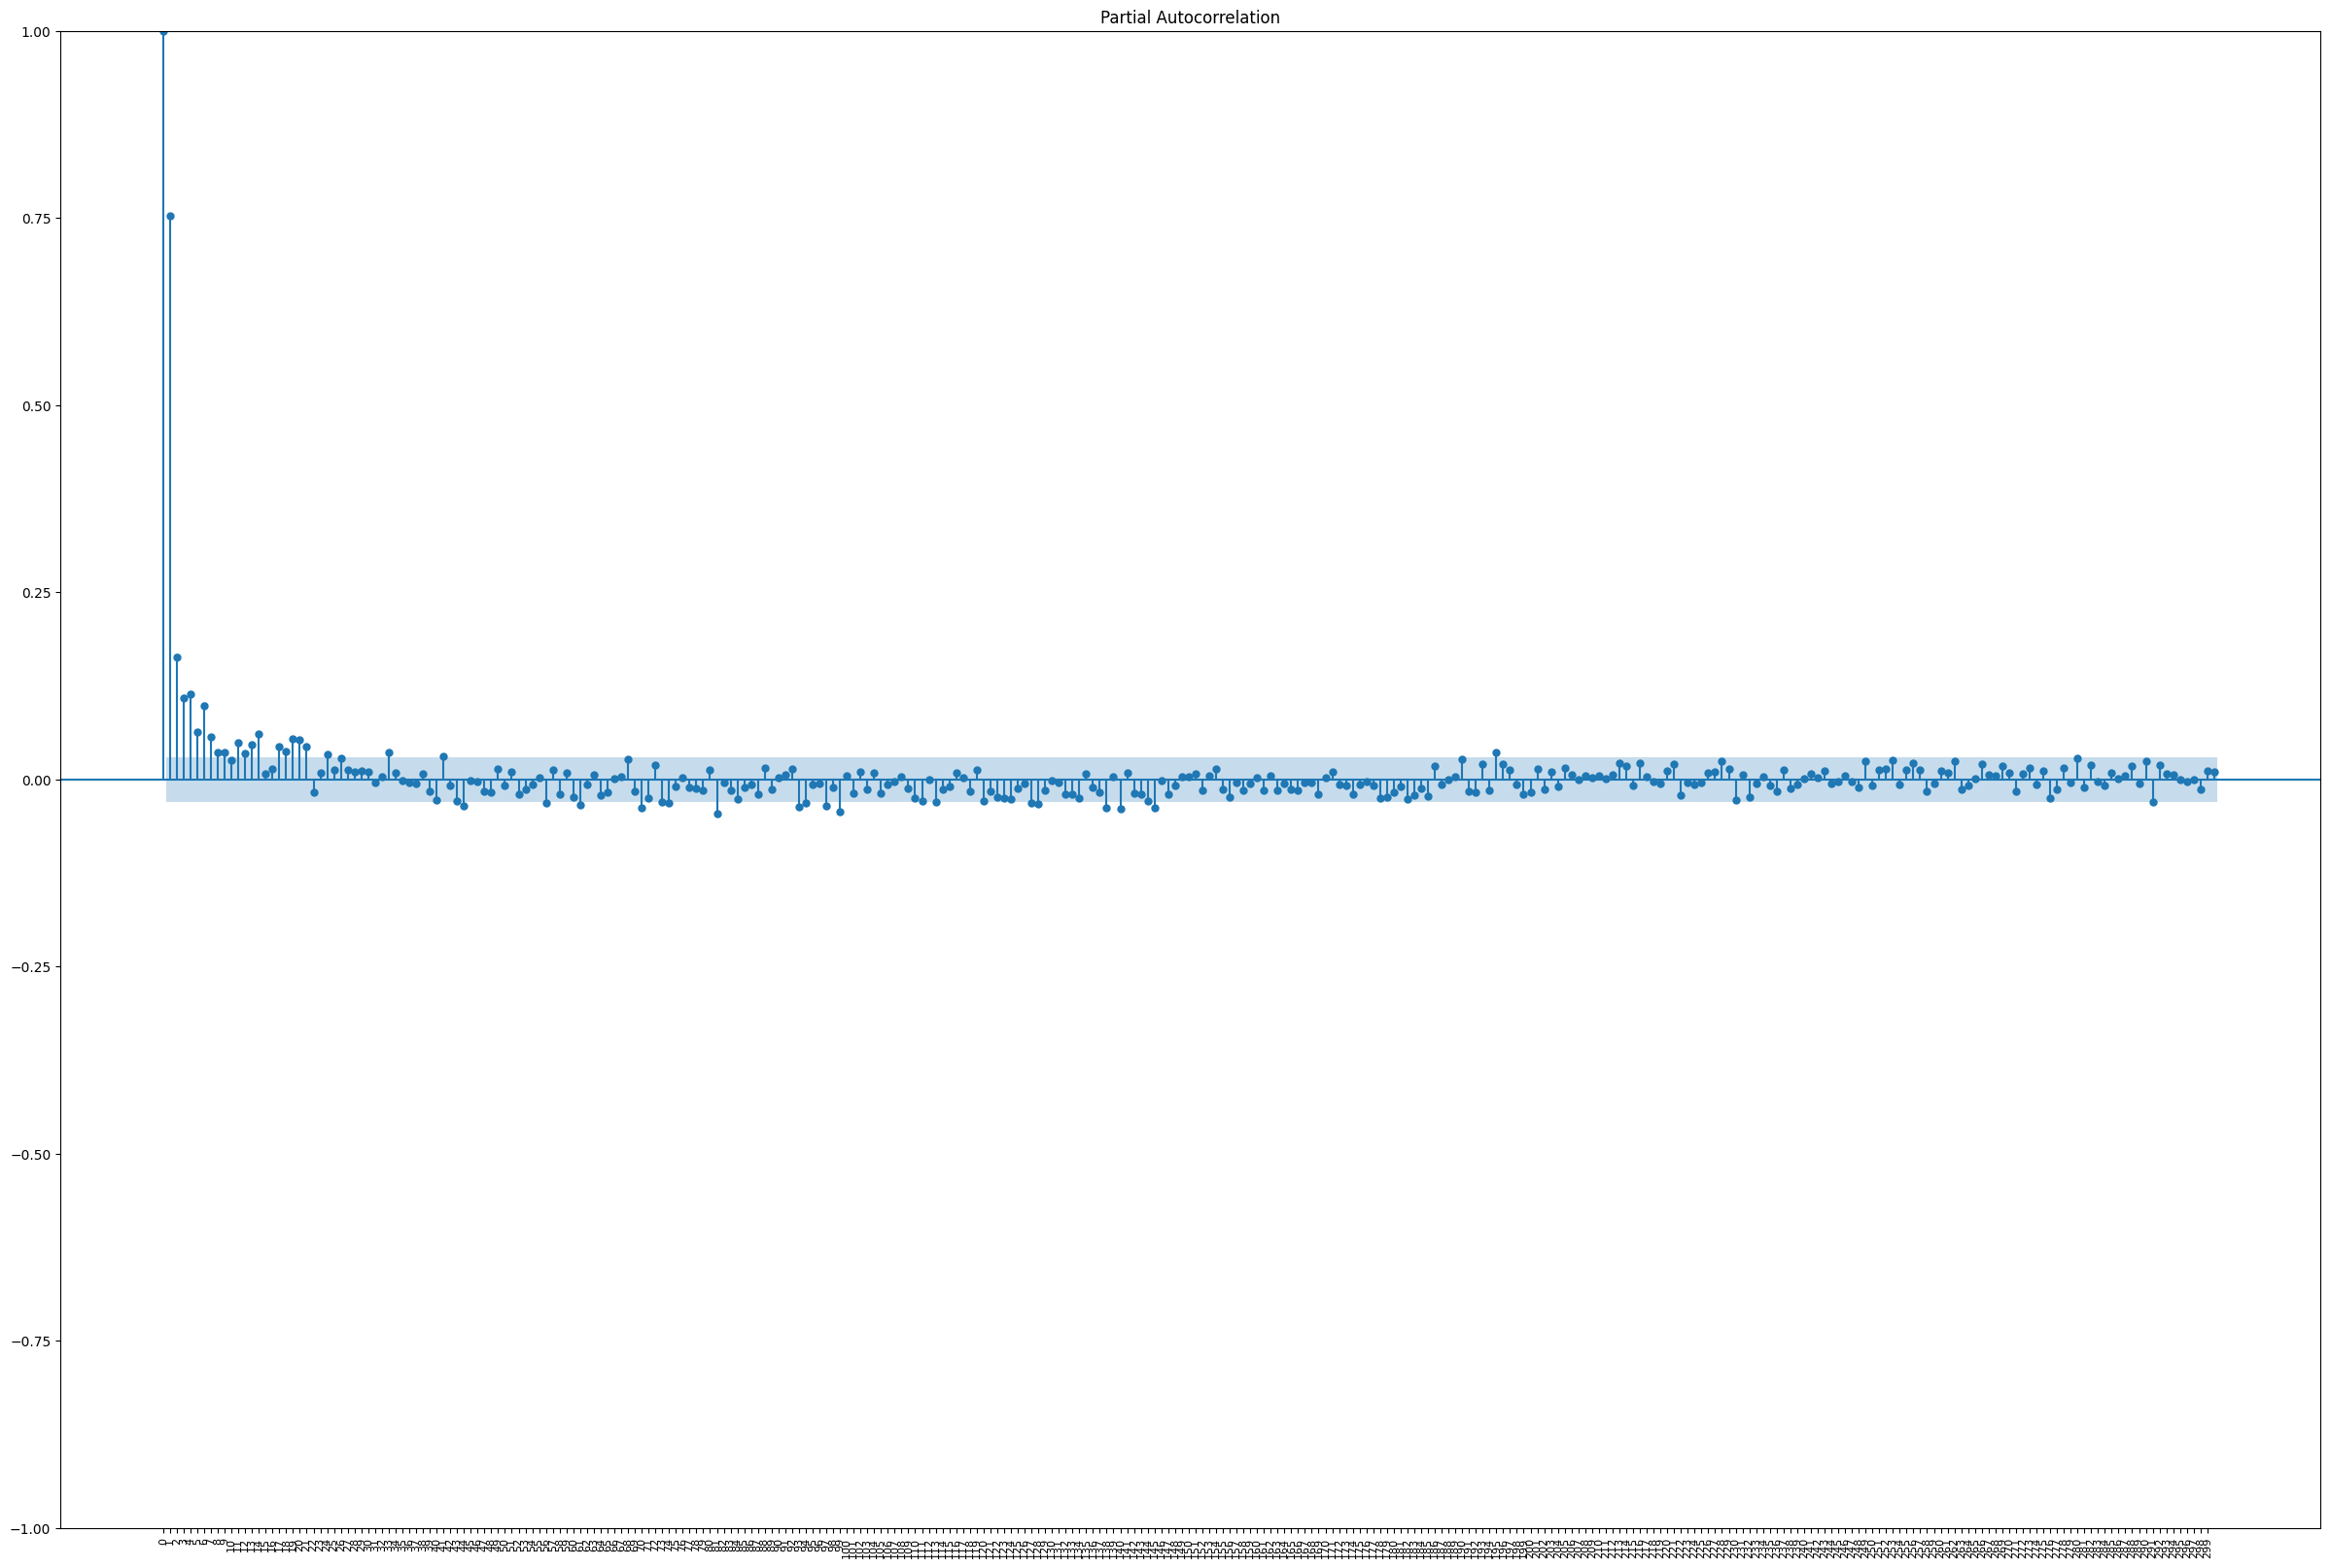

In [118]:
# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(30, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(data_a['Concentration'], lags=300, ax=ax)

# Display the plot
plt.xticks(range(300), rotation='vertical', fontsize=8)
plt.show()

In [119]:
# Define the range of AR, MA, and seasonality values to check
ar_range = range(12)
ma_range = range(12)

# Initialize variables for tracking the best model
best_mse = float('inf')
best_order = None
best_results = None

# Iterate through AR and MA values
for p in ar_range:
    for q in ma_range:
        order = (p, 0, q)  # ARIMA order (p, d, q), here d=0 for ARMA
        model = sm.tsa.ARIMA(data_a['Concentration'], order=order)
        results = model.fit()

        # Calculate Mean Squared Error (MSE)
        fitted_values = results.fittedvalues
        mse = mean_squared_error(data_a['Concentration'], fitted_values)

        # Check if the current model has a lower MSE than the best so far
        if mse < best_mse:
            best_mse = mse
            best_order = order
            best_results = results

# Display the best model's information including AIC, BIC, MSE, and summary
print(f'Best Model Order: {best_order}')
print(f'Best Model AIC: {best_results.aic:.2f}')
print(f'Best Model BIC: {best_results.bic:.2f}')
print(f'Best Model MSE: {best_mse:.2f}')
print(best_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Best Model Order: (10, 0, 11)
Best Model AIC: 37325.46
Best Model BIC: 37472.18
Best Model MSE: 306.39
                               SARIMAX Results                                
Dep. Variable:          Concentration   No. Observations:                 4354
Model:               ARIMA(10, 0, 11)   Log Likelihood              -18639.731
Date:                Mon, 04 Mar 2024   AIC                          37325.463
Time:                        12:49:22   BIC                          37472.176
Sample:                             0   HQIC                         37377.246
                               - 4354                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.0886      3.782     16.683      0.000      55.677      70.500
ar.L1          1.1219      0

In [120]:
# Fit ARMA (10, 0, 11)
order_arma = (10, 0, 11)  # ARIMA order (p, d, q), here d=0 for ARMA
model_arma = sm.tsa.ARIMA(data_a['Concentration'], order=order_arma)
results_arma = model_arma.fit()

# Extract the predicted (fitted) values
fitted_values = pd.DataFrame({
    'FittedValues': results_arma.fittedvalues
})

# Combine the original data_a DataFrame with the fitted values
data['FittedValues'] = fitted_values['FittedValues']

# Display the updated DataFrame
print(data)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues
Date                                                                         
2008-01-01  2008      1    1        18.5000          2        0     63.088600
2008-01-02  2008      1    2        46.1250          3        0     30.084078
2008-01-03  2008      1    3        38.2500          4        0     45.465207
2008-01-04  2008      1    4        33.1250          5        0     41.639229
2008-01-05  2008      1    5        68.2500          6        1     37.831732
...          ...    ...  ...            ...        ...      ...           ...
2019-12-27  2019     12   27        45.2500          5        0     48.942663
2019-12-28  2019     12   28        42.1250          6        1     50.905168
2019-12-29  2019     12   29        32.8750          0        1     48.325494
2019-12-30  2019     12   30        41.6875          1        0     41.297449
2019-12-31  2019     12   31        27.0000          2        0 

##### Model not valid, as Ljung test is 0.02. lower than 0.05.

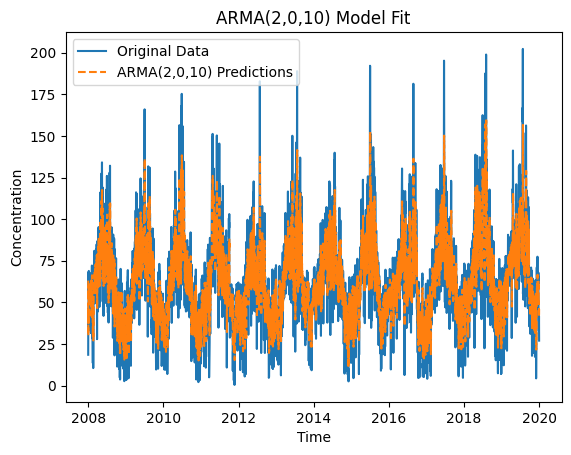

In [121]:
# Plot original data and predicted values
plt.plot(data_a, label='Original Data')
plt.plot(results_arma.fittedvalues, label='ARMA(2,0,10) Predictions', linestyle='--')
plt.title('ARMA(2,0,10) Model Fit')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

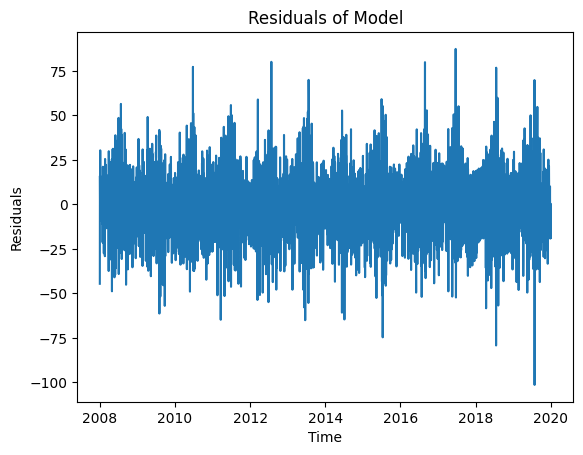

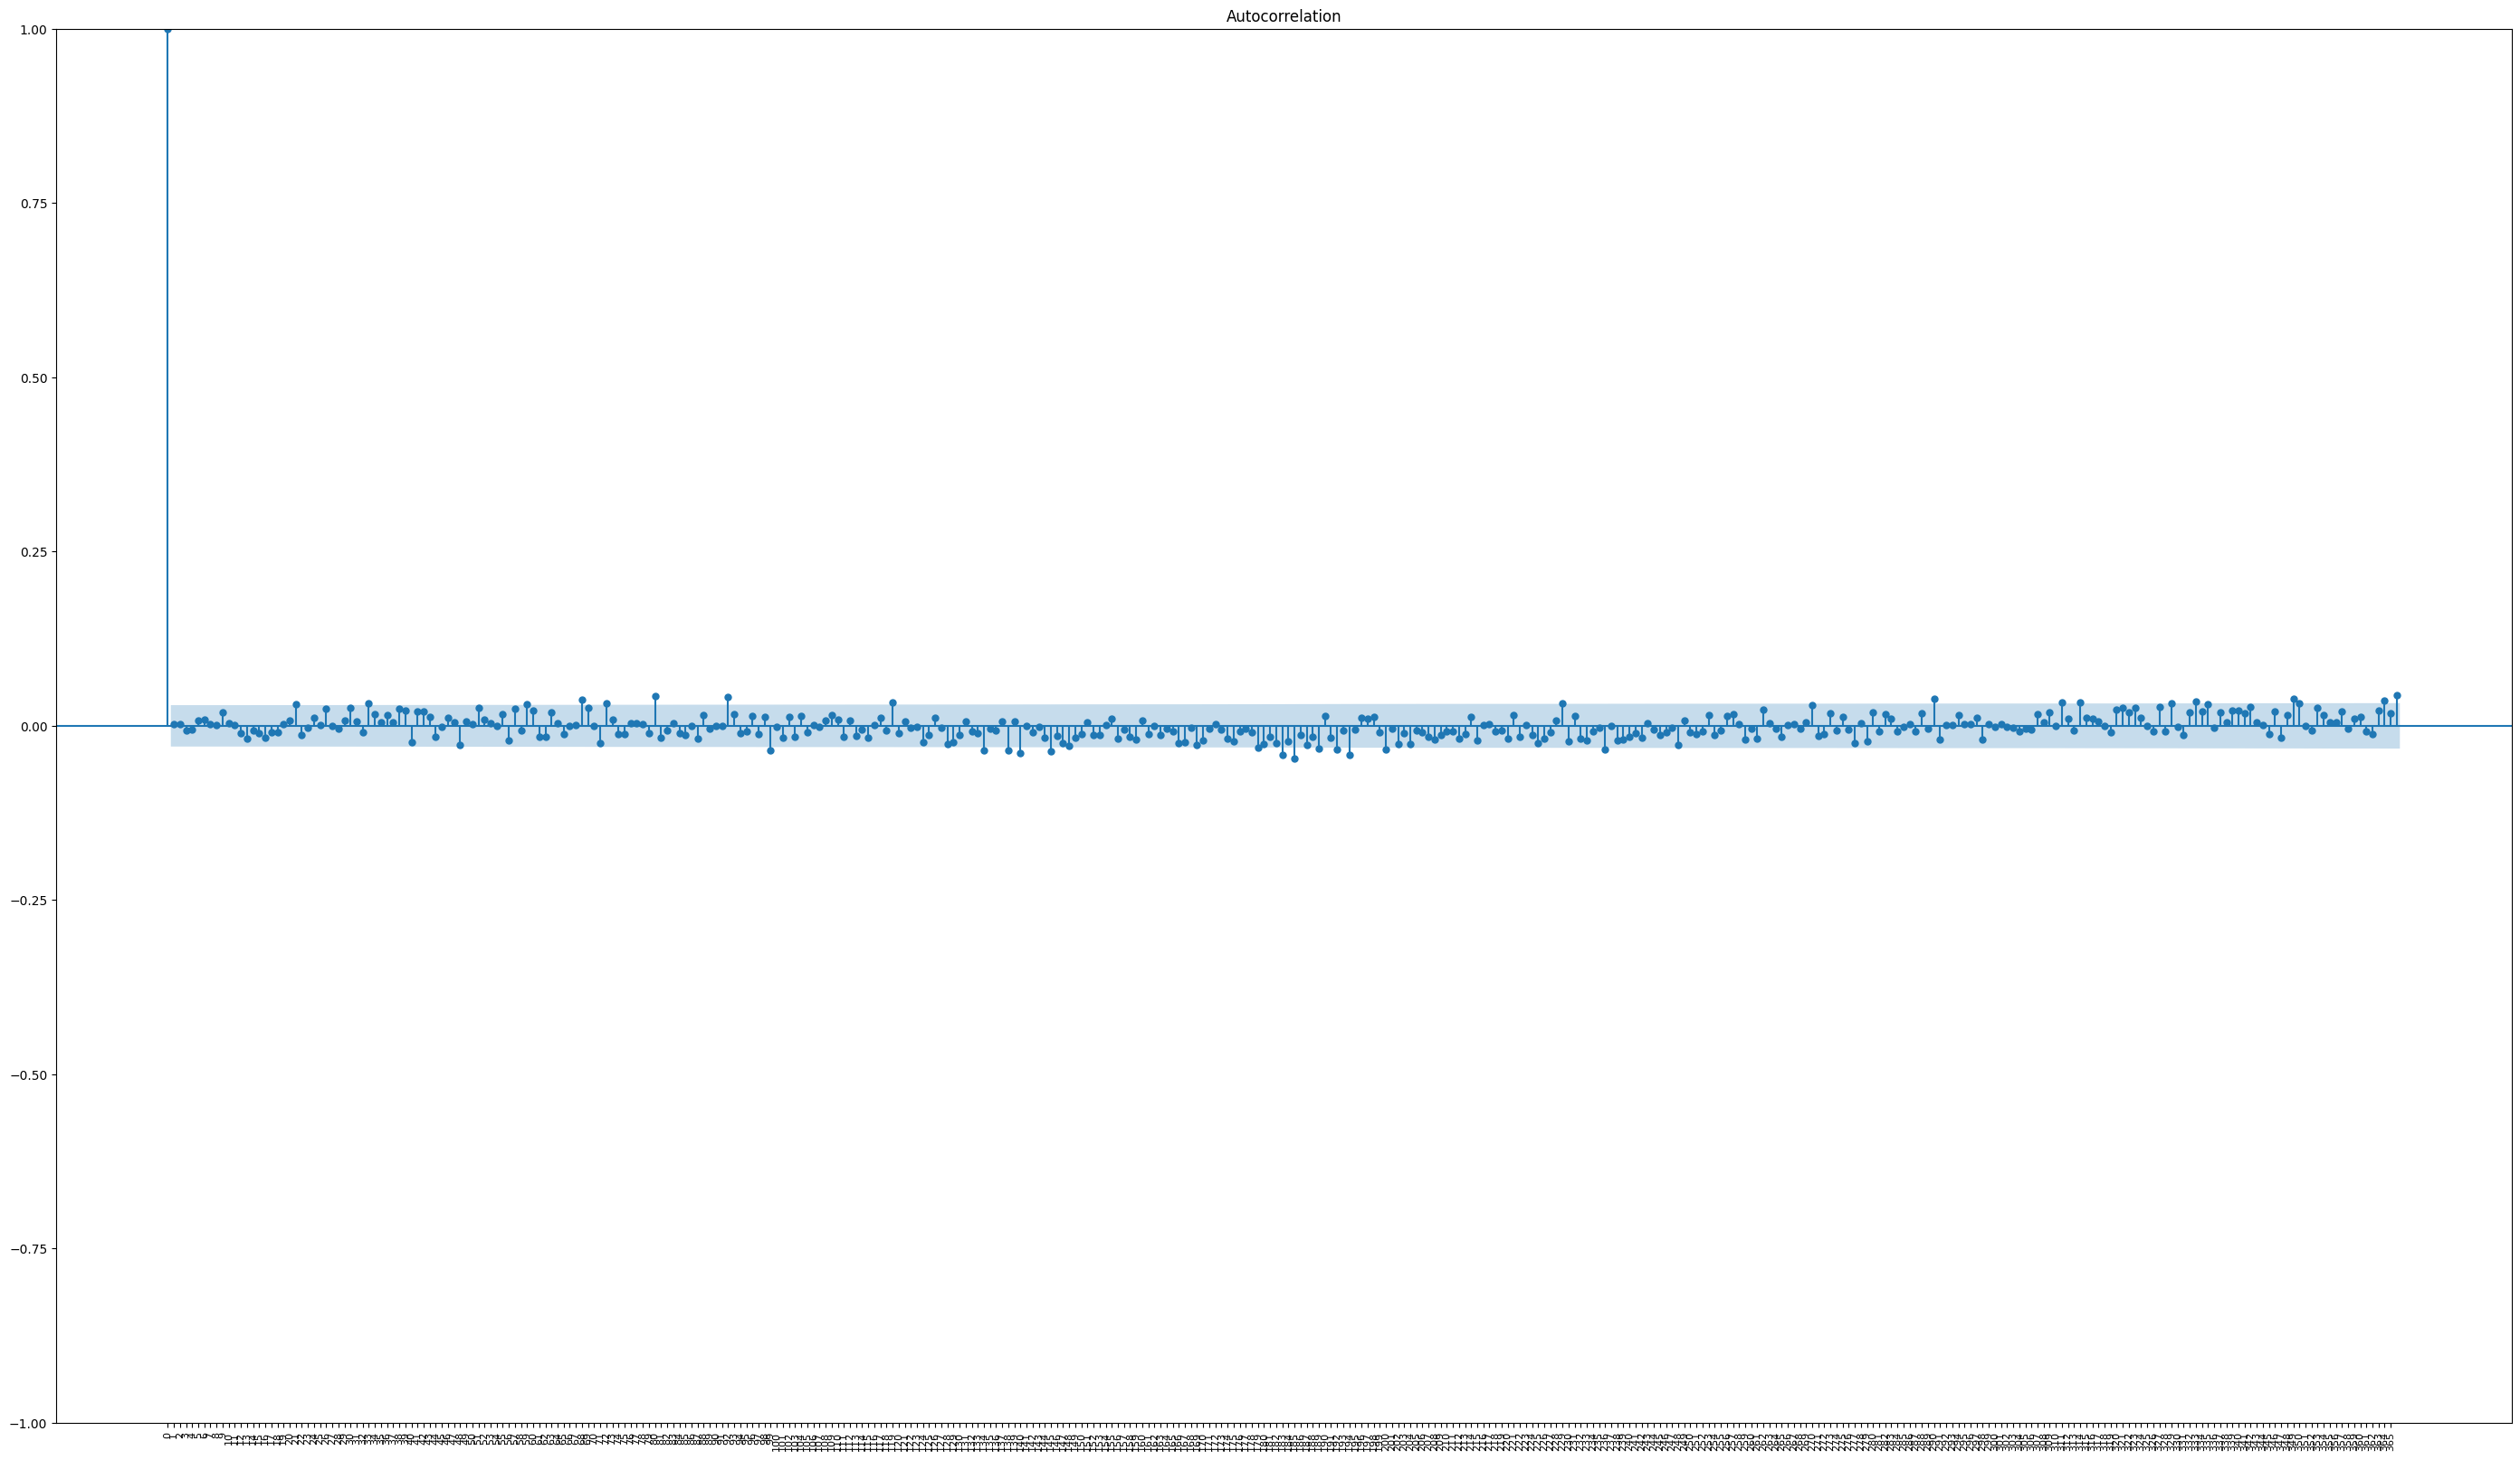

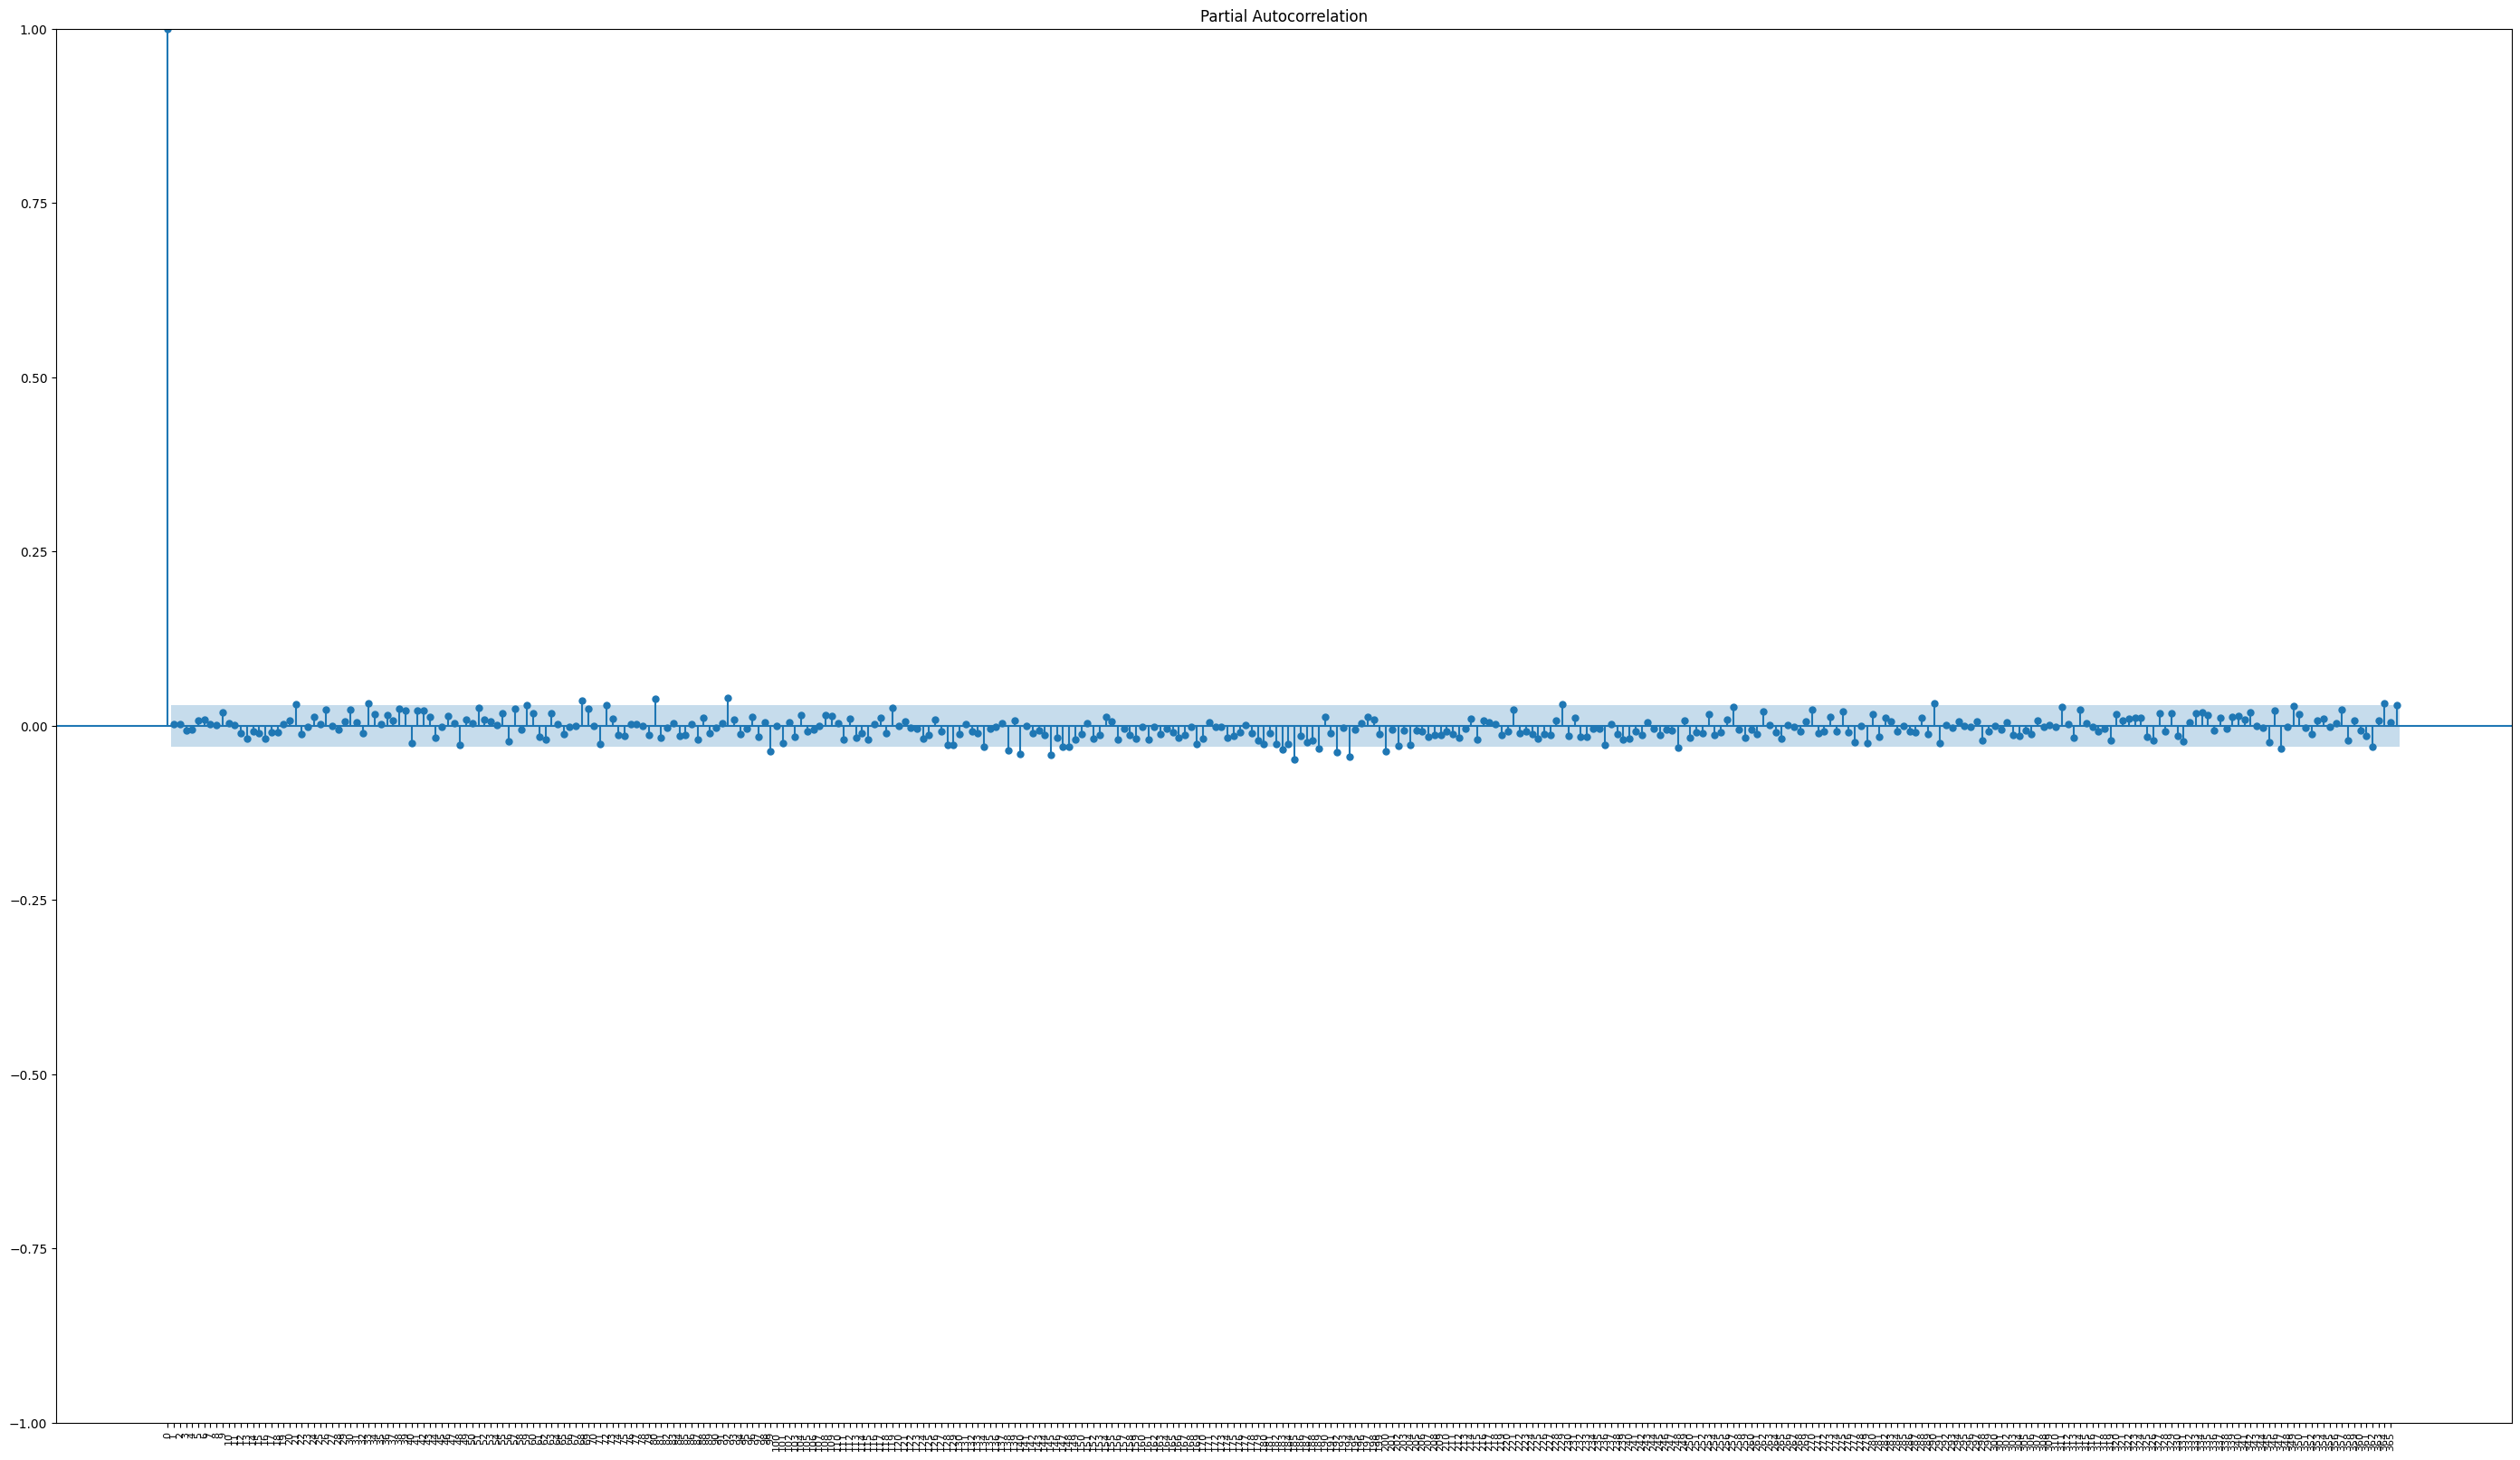

In [122]:
residuals = results_arma.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals of Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
acf_plot = plot_acf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()


# Assuming you have a figure and axis
fig, ax = plt.subplots(figsize=(35, 20))

# Assuming your DataFrame is named 'data_a'
pacf_plot = plot_pacf(residuals, lags=366, ax=ax)

# Display the plot
plt.xticks(range(366), rotation='vertical', fontsize=8)
plt.show()

In [123]:
# Remove NaN values from 'Concentration' and 'FittedValues' columns
mask = ~np.isnan(data['Concentration']) & ~np.isnan(data['FittedValues'])
y_true = data['Concentration'][mask]
y_pred = data['FittedValues'][mask]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

Mean Squared Error (MSE): 310.07


The MSE is very high, its 310.07

## Now we calculate the lagged values of Concentration (making a new variable with the value from day before, a week before, a month before, and a year before)

In [124]:
# Assuming 'Date' is your index
data['day_lag1'] = data['Concentration'].shift(1)
data['day_lag7'] = data['Concentration'].shift(7)

# If 'Date' is not the index, you can use the following instead
# data['day_lag1'] = data['Concentration'].shift(1).reset_index(drop=True)

print(data.head())

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1         18.500          2        0     63.088600   
2008-01-02  2008      1    2         46.125          3        0     30.084078   
2008-01-03  2008      1    3         38.250          4        0     45.465207   
2008-01-04  2008      1    4         33.125          5        0     41.639229   
2008-01-05  2008      1    5         68.250          6        1     37.831732   

            day_lag1  day_lag7  
Date                            
2008-01-01       NaN       NaN  
2008-01-02    18.500       NaN  
2008-01-03    46.125       NaN  
2008-01-04    38.250       NaN  
2008-01-05    33.125       NaN  


In [125]:
# Assuming data is your DataFrame
data['day_lag30'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year']) &
        (data['Month'] == row['Month'] - 1) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Month'] > 1 and not data.loc[
        (data['Year'] == row['Year']) &
        (data['Month'] == row['Month'] - 1) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

data['day_lag365'] = data.apply(
    lambda row: data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].iloc[0] if row['Year'] > data['Year'].min() and not data.loc[
        (data['Year'] == row['Year'] - 1) &
        (data['Month'] == row['Month']) &
        (data['Day'] == row['Day']),
        'Concentration'].empty else np.nan, axis=1
)

In [126]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for day_lag1 with dropped values: 419.17309283088235
MSE for day_lag7 with dropped values: 864.3185927825077
MSE for day_lag30 with dropped values: 1011.7208458301084
MSE for day_lag365 with dropped values: 927.5606811145511


# Extra PreProc

## Introduction of Holiday variable

In [127]:
# List of holiday dates with months and days
holiday_dates = {
    (1, 1),   # New Year's Day
    (1, 6),   # Epiphany
    (2, 14),  # Valentine's Day
    (3, 20),  # March Equinox
    (3, 29),  # Good Friday
    (3, 31),  # Easter Sunday
    (4, 1),   # Easter Monday
    (5, 1),   # Labor Day / May Day
    (5, 8),   # Iris Day (Brussels Regional holiday)
    (5, 9),   # Ascension Day
    (5, 10),  # Day after Ascension Day
    (5, 12),  # Mothers' Day
    (5, 19),  # Whit Sunday
    (5, 20),  # Whit Monday
    (6, 9),   # Fathers' Day
    (6, 20),  # June Solstice
    (7, 11),  # Day of the Flemish Community (Regional holiday in some provinces)
    (7, 21),  # Belgian National Day
    (8, 15),  # Assumption of Mary
    (9, 15),  # Day of the Walloon Region (Regional holiday in Namur)
    (9, 22),  # September Equinox
    (9, 27),  # Day of the French Community (Regional holiday in some provinces)
    (10, 27), # Daylight Saving Time ends
    (10, 31), # Halloween
    (11, 1),  # All Saints' Day
    (11, 11), # Armistice Day
    (11, 15), # Day of the German-speaking Community (Regional holiday in Liège)
    (12, 6),  # St. Nicholas Day
    (12, 21), # December Solstice
    (12, 24), # Christmas Eve
    (12, 25), # Christmas Day
    (12, 26), # Boxing Day
    (12, 31)  # New Year's Eve
}

# Create a new column 'IsHoliday' and set it to 1 for holidays, 0 otherwise
data['IsHoliday'] = data.apply(lambda row: 1 if (row['Month'], row['Day']) in holiday_dates else 0, axis=1)

# Display the updated DataFrame
print(data)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1        18.5000          2        0     63.088600   
2008-01-02  2008      1    2        46.1250          3        0     30.084078   
2008-01-03  2008      1    3        38.2500          4        0     45.465207   
2008-01-04  2008      1    4        33.1250          5        0     41.639229   
2008-01-05  2008      1    5        68.2500          6        1     37.831732   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27        45.2500          5        0     48.942663   
2019-12-28  2019     12   28        42.1250          6        1     50.905168   
2019-12-29  2019     12   29        32.8750          0        1     48.325494   
2019-12-30  2019     12   30        41.6875          1        0     41.297449   
2019-12-31  2019     12   31

## Introduction of Season Variable

In [128]:
# Define the season based on the month with numerical values
data['Season'] = data['Month'].apply(lambda x:
                                     1 if (x == 12 or x <= 2) else
                                     2 if (x >= 3 and x <= 5) else
                                     3 if (x >= 6 and x <= 8) else
                                     4 if (x >= 9 and x <= 11) else None)

# Display the updated DataFrame
print(data)
data['Season'].unique()

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1        18.5000          2        0     63.088600   
2008-01-02  2008      1    2        46.1250          3        0     30.084078   
2008-01-03  2008      1    3        38.2500          4        0     45.465207   
2008-01-04  2008      1    4        33.1250          5        0     41.639229   
2008-01-05  2008      1    5        68.2500          6        1     37.831732   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-27  2019     12   27        45.2500          5        0     48.942663   
2019-12-28  2019     12   28        42.1250          6        1     50.905168   
2019-12-29  2019     12   29        32.8750          0        1     48.325494   
2019-12-30  2019     12   30        41.6875          1        0     41.297449   
2019-12-31  2019     12   31

array([1, 2, 3, 4])

## Removal of missing values?

In [129]:
# Check for missing values in the 'Concentration' column
rows_with_missing_values = data[data['Concentration'].isna()]

# Display rows with missing values
print("Rows with missing values in 'Concentration' column:")
print(rows_with_missing_values)

Rows with missing values in 'Concentration' column:
            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-02-11  2008      2   11            NaN          1        0     50.398943   
2008-02-12  2008      2   12            NaN          2        0     49.418922   
2008-02-13  2008      2   13            NaN          3        0     42.494426   
2008-02-14  2008      2   14            NaN          4        0     39.997328   
2008-05-18  2008      5   18            NaN          0        1     78.208064   
...          ...    ...  ...            ...        ...      ...           ...   
2019-03-05  2019      3    5            NaN          2        0     76.815088   
2019-03-06  2019      3    6            NaN          3        0     78.680839   
2019-03-07  2019      3    7            NaN          4        0     78.092582   
2019-03-08  2019      3    8            NaN          5   

In [130]:
# Remove rows with null values in the 'Concentration' column in-place
data.dropna(subset=['Concentration'], inplace=True)

# Display the modified data
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4274 entries, 2008-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4274 non-null   int64  
 1   Month          4274 non-null   int64  
 2   Day            4274 non-null   int64  
 3   Concentration  4274 non-null   float64
 4   DayOfWeek      4274 non-null   int64  
 5   Weekend        4274 non-null   int64  
 6   FittedValues   4274 non-null   float64
 7   day_lag1       4237 non-null   float64
 8   day_lag7       4188 non-null   float64
 9   day_lag30      3718 non-null   float64
 10  day_lag365     3813 non-null   float64
 11  IsHoliday      4274 non-null   int64  
 12  Season         4274 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 467.5 KB
None


,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season
Date,,,,,,,,,,,,,
2008-01-01,2008,1,1,18.500,2,0,63.088600,NaN,NaN,NaN,NaN,1,1
2008-01-02,2008,1,2,46.125,3,0,30.084078,18.500,NaN,NaN,NaN,0,1
2008-01-03,2008,1,3,38.250,4,0,45.465207,46.125,NaN,NaN,NaN,0,1
2008-01-04,2008,1,4,33.125,5,0,41.639229,38.250,NaN,NaN,NaN,0,1
2008-01-05,2008,1,5,68.250,6,1,37.831732,33.125,NaN,NaN,NaN,0,1


In [131]:
###Now we interpolate the missing values of day_lag1, day_lag7, day_lag30 and day_lag365
# Assuming data_a is your DataFrame
columns_to_interpolate = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Interpolate missing values in specified columns
data[columns_to_interpolate] = data[columns_to_interpolate].interpolate(method='polynomial', order=2)

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4274 entries, 2008-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           4274 non-null   int64  
 1   Month          4274 non-null   int64  
 2   Day            4274 non-null   int64  
 3   Concentration  4274 non-null   float64
 4   DayOfWeek      4274 non-null   int64  
 5   Weekend        4274 non-null   int64  
 6   FittedValues   4274 non-null   float64
 7   day_lag1       4273 non-null   float64
 8   day_lag7       4267 non-null   float64
 9   day_lag30      4242 non-null   float64
 10  day_lag365     3916 non-null   float64
 11  IsHoliday      4274 non-null   int64  
 12  Season         4274 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 467.5 KB


In [133]:
# Assuming data is your DataFrame
missing_rows = data[data['day_lag30'].isnull()]

# Display the rows with missing values in 'day_lag30'
print(missing_rows)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2008-01-01  2008      1    1         18.500          2        0     63.088600   
2008-01-02  2008      1    2         46.125          3        0     30.084078   
2008-01-03  2008      1    3         38.250          4        0     45.465207   
2008-01-04  2008      1    4         33.125          5        0     41.639229   
2008-01-05  2008      1    5         68.250          6        1     37.831732   
2008-01-06  2008      1    6         57.125          0        1     59.300473   
2008-01-07  2008      1    7         68.875          1        0     53.070385   
2008-01-08  2008      1    8         56.750          2        0     60.897319   
2008-01-09  2008      1    9         56.625          3        0     56.772507   
2008-01-10  2008      1   10         50.125          4        0     54.548048   
2008-01-11  2008      1   11

In [134]:
# Columns to calculate MSE for
lag_columns = ['day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Create a new DataFrame for the dropped missing values
data_dropped = data.dropna()

# Loop through lag columns and calculate MSE for dropped DataFrame
for lag_column in lag_columns:
    mse_dropped = mean_squared_error(data_dropped['Concentration'], data_dropped[lag_column], squared=True)
    print(f'MSE for {lag_column} with dropped values: {mse_dropped}')

MSE for day_lag1 with dropped values: 390.85057110424896
MSE for day_lag7 with dropped values: 827.784929959324
MSE for day_lag30 with dropped values: 1586.5147773392025
MSE for day_lag365 with dropped values: 894.9643169322843


In [135]:
##We remove the values from the year 2008
data = data[data['Year'] != 2008]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3916 entries, 2009-01-01 to 2019-12-31
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Year           3916 non-null   int64  
 1   Month          3916 non-null   int64  
 2   Day            3916 non-null   int64  
 3   Concentration  3916 non-null   float64
 4   DayOfWeek      3916 non-null   int64  
 5   Weekend        3916 non-null   int64  
 6   FittedValues   3916 non-null   float64
 7   day_lag1       3916 non-null   float64
 8   day_lag7       3916 non-null   float64
 9   day_lag30      3915 non-null   float64
 10  day_lag365     3916 non-null   float64
 11  IsHoliday      3916 non-null   int64  
 12  Season         3916 non-null   int64  
dtypes: float64(6), int64(7)
memory usage: 428.3 KB


In [136]:
# Assuming data is your DataFrame
missing_rows = data[data['day_lag30'].isnull()]

# Display the rows with missing values in 'day_lag30'
print(missing_rows)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2019-12-31  2019     12   31           27.0          2        0     45.876668   

            day_lag1  day_lag7  day_lag30  day_lag365  IsHoliday  Season  
Date                                                                      
2019-12-31   41.6875    67.875        NaN      26.375          1       1  


In [137]:
data = data.dropna(subset=['day_lag30'])

## Now we normalize and Converge the signals (days) from euclidian to the angular domain

In [138]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select columns to normalize
columns_to_normalize = ['Concentration', 'FittedValues', 'day_lag1', 'day_lag7', 'day_lag30', 'day_lag365']

# Fit and transform the selected columns
data_normalized = data.copy()  # Make a copy to avoid modifying the original data
data_normalized[columns_to_normalize] = scaler.fit_transform(data_normalized[columns_to_normalize])

# Display the normalized data
print(data_normalized)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2009-01-01  2009      1    1       0.059424          4        0      0.043186   
2009-01-02  2009      1    2       0.022903          5        0      0.071267   
2009-01-03  2009      1    3       0.040854          6        1      0.031817   
2009-01-04  2009      1    4       0.084184          0        1      0.032848   
2009-01-05  2009      1    5       0.130610          1        0      0.057207   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-26  2019     12   26       0.202105          4        0      0.329243   
2019-12-27  2019     12   27       0.222222          5        0      0.251939   
2019-12-28  2019     12   28       0.206747          6        1      0.265230   
2019-12-29  2019     12   29       0.160941          0        1      0.247760   
2019-12-30  2019     12   30

In [139]:
## Assuming data_normalized is the DataFrame with normalized columns
#data_restored = data_normalized.copy()

# Inverse transform the selected columns
#data_restored[columns_to_normalize] = scaler.inverse_transform(data_normalized[columns_to_normalize])

# Display the restored data
#print(data_restored)

In [140]:
data_normalized.head()

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season
Date,,,,,,,,,,,,,
2009-01-01,2009,1,1,0.059424,4,0,0.043186,0.033485,0.276594,0.446126,0.267800,1,1
2009-01-02,2009,1,2,0.022903,5,0,0.071267,0.076630,0.219491,0.489132,0.379900,0,1
2009-01-03,2009,1,3,0.040854,6,1,0.031817,0.040777,0.153647,0.527571,0.347944,0,1
2009-01-04,2009,1,4,0.084184,0,1,0.032848,0.058400,0.169380,0.561444,0.327147,0,1
2009-01-05,2009,1,5,0.130610,1,0,0.057207,0.100937,0.185695,0.590750,0.469681,0,1


## Transforming the dates using Sinusoidal Conversion

In [141]:
def days_in_month(month, year):
    if month == 2:
        if (year % 4 == 0):
            return 29  # Leap year, February has 29 days
        else:
            return 28  # Non-leap year, February has 28 days
    elif month in [4, 6, 9, 11]:
        return 30  # April, June, September, and November have 30 days
    else:
        return 31  # January, March, May, July, August, October, and December have 31 days

# Apply the days_in_month function to create a new column 'Days_In_Month'
data_normalized['Days_In_Month'] = data_normalized.apply(lambda row: days_in_month(row['Month'], row['Year']), axis=1)

data_normalized['Date'] = pd.to_datetime(data_normalized[['Year', 'Month', 'Day']])

print(data_normalized)

            Year  Month  Day  Concentration  DayOfWeek  Weekend  FittedValues  \
Date                                                                            
2009-01-01  2009      1    1       0.059424          4        0      0.043186   
2009-01-02  2009      1    2       0.022903          5        0      0.071267   
2009-01-03  2009      1    3       0.040854          6        1      0.031817   
2009-01-04  2009      1    4       0.084184          0        1      0.032848   
2009-01-05  2009      1    5       0.130610          1        0      0.057207   
...          ...    ...  ...            ...        ...      ...           ...   
2019-12-26  2019     12   26       0.202105          4        0      0.329243   
2019-12-27  2019     12   27       0.222222          5        0      0.251939   
2019-12-28  2019     12   28       0.206747          6        1      0.265230   
2019-12-29  2019     12   29       0.160941          0        1      0.247760   
2019-12-30  2019     12   30

In [142]:
def apply_sin_cos_conversion(day, days_month):
    angle = 2 * np.pi * (day / days_month)
    sin_value = np.sin(angle)
    cos_value = np.cos(angle)
    return sin_value, cos_value

# Assuming 'date' column is of datetime type
data_normalized['sin_date'], data_normalized['cos_date'] = zip(*data_normalized.apply(lambda row: apply_sin_cos_conversion(row['Date'].day, row['Days_In_Month']), axis=1))

In [143]:
data_normalized = data_normalized.drop(columns=['Date','Days_In_Month'])

In [144]:
def apply_sin_cos_conversion(day_of_week):
    angle = 2 * np.pi * (day_of_week / 7)
    sin_value = np.sin(angle)
    cos_value = np.cos(angle)
    return sin_value, cos_value

data_normalized['Day_of_Week_Sin'], data_normalized['Day_of_Week_Cos'] = zip(*data_normalized['DayOfWeek'].apply(apply_sin_cos_conversion))

In [145]:
data_normalized

,Year,Month,Day,Concentration,DayOfWeek,Weekend,FittedValues,day_lag1,day_lag7,day_lag30,day_lag365,IsHoliday,Season,sin_date,cos_date,Day_of_Week_Sin,Day_of_Week_Cos
Date,,,,,,,,,,,,,,,,,
2009-01-01,2009,1,1,0.059424,4,0,0.043186,0.033485,0.276594,0.446126,0.267800,1,1,0.201299,0.979530,-0.433884,-0.900969
2009-01-02,2009,1,2,0.022903,5,0,0.071267,0.076630,0.219491,0.489132,0.379900,0,1,0.394356,0.918958,-0.974928,-0.222521
2009-01-03,2009,1,3,0.040854,6,1,0.031817,0.040777,0.153647,0.527571,0.347944,0,1,0.571268,0.820763,-0.781831,0.623490
2009-01-04,2009,1,4,0.084184,0,1,0.032848,0.058400,0.169380,0.561444,0.327147,0,1,0.724793,0.688967,0.000000,1.000000
2009-01-05,2009,1,5,0.130610,1,0,0.057207,0.100937,0.185695,0.590750,0.469681,0,1,0.848644,0.528964,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,2019,12,26,0.202105,4,0,0.329243,0.304510,0.344477,0.376113,0.221387,1,1,-0.848644,0.528964,-0.433884,-0.900969
2019-12-27,2019,12,27,0.222222,5,0,0.251939,0.216700,0.366328,0.391490,0.247257,0,1,-0.724793,0.688967,-0.974928,-0.222521
2019-12-28,2019,12,28,0.206747,6,1,0.265230,0.236450,0.341855,0.373400,0.221387,0,1,-0.571268,0.820763,-0.781831,0.623490


In [146]:
data_normalized.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3915 entries, 2009-01-01 to 2019-12-30
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             3915 non-null   int64  
 1   Month            3915 non-null   int64  
 2   Day              3915 non-null   int64  
 3   Concentration    3915 non-null   float64
 4   DayOfWeek        3915 non-null   int64  
 5   Weekend          3915 non-null   int64  
 6   FittedValues     3915 non-null   float64
 7   day_lag1         3915 non-null   float64
 8   day_lag7         3915 non-null   float64
 9   day_lag30        3915 non-null   float64
 10  day_lag365       3915 non-null   float64
 11  IsHoliday        3915 non-null   int64  
 12  Season           3915 non-null   int64  
 13  sin_date         3915 non-null   float64
 14  cos_date         3915 non-null   float64
 15  Day_of_Week_Sin  3915 non-null   float64
 16  Day_of_Week_Cos  3915 non-null   float64
d